<a href="https://colab.research.google.com/github/KUNALCHAVAN1234/deep-learning/blob/graph/Cordi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np

# Load your data files (make sure paths are correct)
#OUT_DIR = Path("/content/out")
users = pd.read_parquet("users.parquet")
edges = pd.read_parquet("edges_fused.parquet")
user_embeddings = np.load("user_embeddings.npy")
user_index = pd.read_csv("user_index.csv")

# 1. Mapping for node indices (very important!)
uid_to_idx = {str(uid): i for i, uid in enumerate(user_index["user_id"].astype(str))}

# 2. Node features
x = torch.tensor(user_embeddings, dtype=torch.float)

# 3. Edge index
edges["src_idx"] = edges["src_user_id"].astype(str).map(uid_to_idx)
edges["dst_idx"] = edges["dst_user_id"].astype(str).map(uid_to_idx)
edges = edges.dropna(subset=["src_idx", "dst_idx"])
edge_index = torch.tensor(np.stack([edges["src_idx"].values, edges["dst_idx"].values]), dtype=torch.long)

# 4. Labels + split masks
user_index["user_id"] = user_index["user_id"].astype(str)
users_simple = users.drop_duplicates(subset=["user_id"])[["user_id", "label", "split"]]
users_simple["user_id"] = users_simple["user_id"].astype(str)
merged = user_index.merge(users_simple, on="user_id", how="left")
y = torch.tensor(merged["label"].fillna(-1).values, dtype=torch.long)
train_mask = torch.tensor((merged["split"] == "train").values, dtype=torch.bool)
val_mask   = torch.tensor((merged["split"] == "dev").values, dtype=torch.bool)
test_mask  = torch.tensor((merged["split"] == "test").values, dtype=torch.bool)

# 5. Create PyG Data object FOR GNN
data = Data(x=x, edge_index=edge_index, y=y)
data.train_mask = train_mask; data.val_mask = val_mask; data.test_mask = test_mask

print(data)
print(f"Nodes: {data.num_nodes}, Edges: {data.num_edges}, Features: {data.num_features}")

Data(x=[11746, 384], edge_index=[2, 133699], y=[11746], train_mask=[11746], val_mask=[11746], test_mask=[11746])
Nodes: 11746, Edges: 133699, Features: 384


In [ ]:
# Check which classes exist in your data
print("Unique labels in dataset:", data.y.unique())

Unique labels in dataset: tensor([0, 1])


In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class BotGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)  # Change to 3 if you have 3 classes!

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = BotGNN(hidden_channels=64)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]
        accs.append(int(correct.sum()) / int(mask.sum()))
    return accs, pred

print("Starting training...")
for epoch in range(101):
    loss = train()
    if epoch % 20 == 0:
        (train_acc, val_acc, test_acc), _ = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Starting training...
Epoch: 000, Loss: 0.6921, Train: 0.6021, Val: 0.5898, Test: 0.5772
Epoch: 020, Loss: 0.6083, Train: 0.6762, Val: 0.6830, Test: 0.6445
Epoch: 040, Loss: 0.5632, Train: 0.7135, Val: 0.7030, Test: 0.6726
Epoch: 060, Loss: 0.5484, Train: 0.7159, Val: 0.7021, Test: 0.6658
Epoch: 080, Loss: 0.5400, Train: 0.7342, Val: 0.7136, Test: 0.6871
Epoch: 100, Loss: 0.5391, Train: 0.7381, Val: 0.7038, Test: 0.6829


In [ ]:
from sklearn.metrics import classification_report

(train_acc, val_acc, test_acc), preds = test()
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = preds[data.test_mask].cpu().numpy()

print("\nFinal Test Accuracy:", test_acc)
print("\n=== GNN Classification Report ===")
print(classification_report(y_true, y_pred, target_names=['Human', 'Bot'], digits=4))


Final Test Accuracy: 0.6828644501278772

=== GNN Classification Report ===
              precision    recall  f1-score   support

       Human     0.6467    0.6827    0.6643       539
         Bot     0.7169    0.6830    0.6995       634

    accuracy                         0.6829      1173
   macro avg     0.6818    0.6829    0.6819      1173
weighted avg     0.6847    0.6829    0.6833      1173



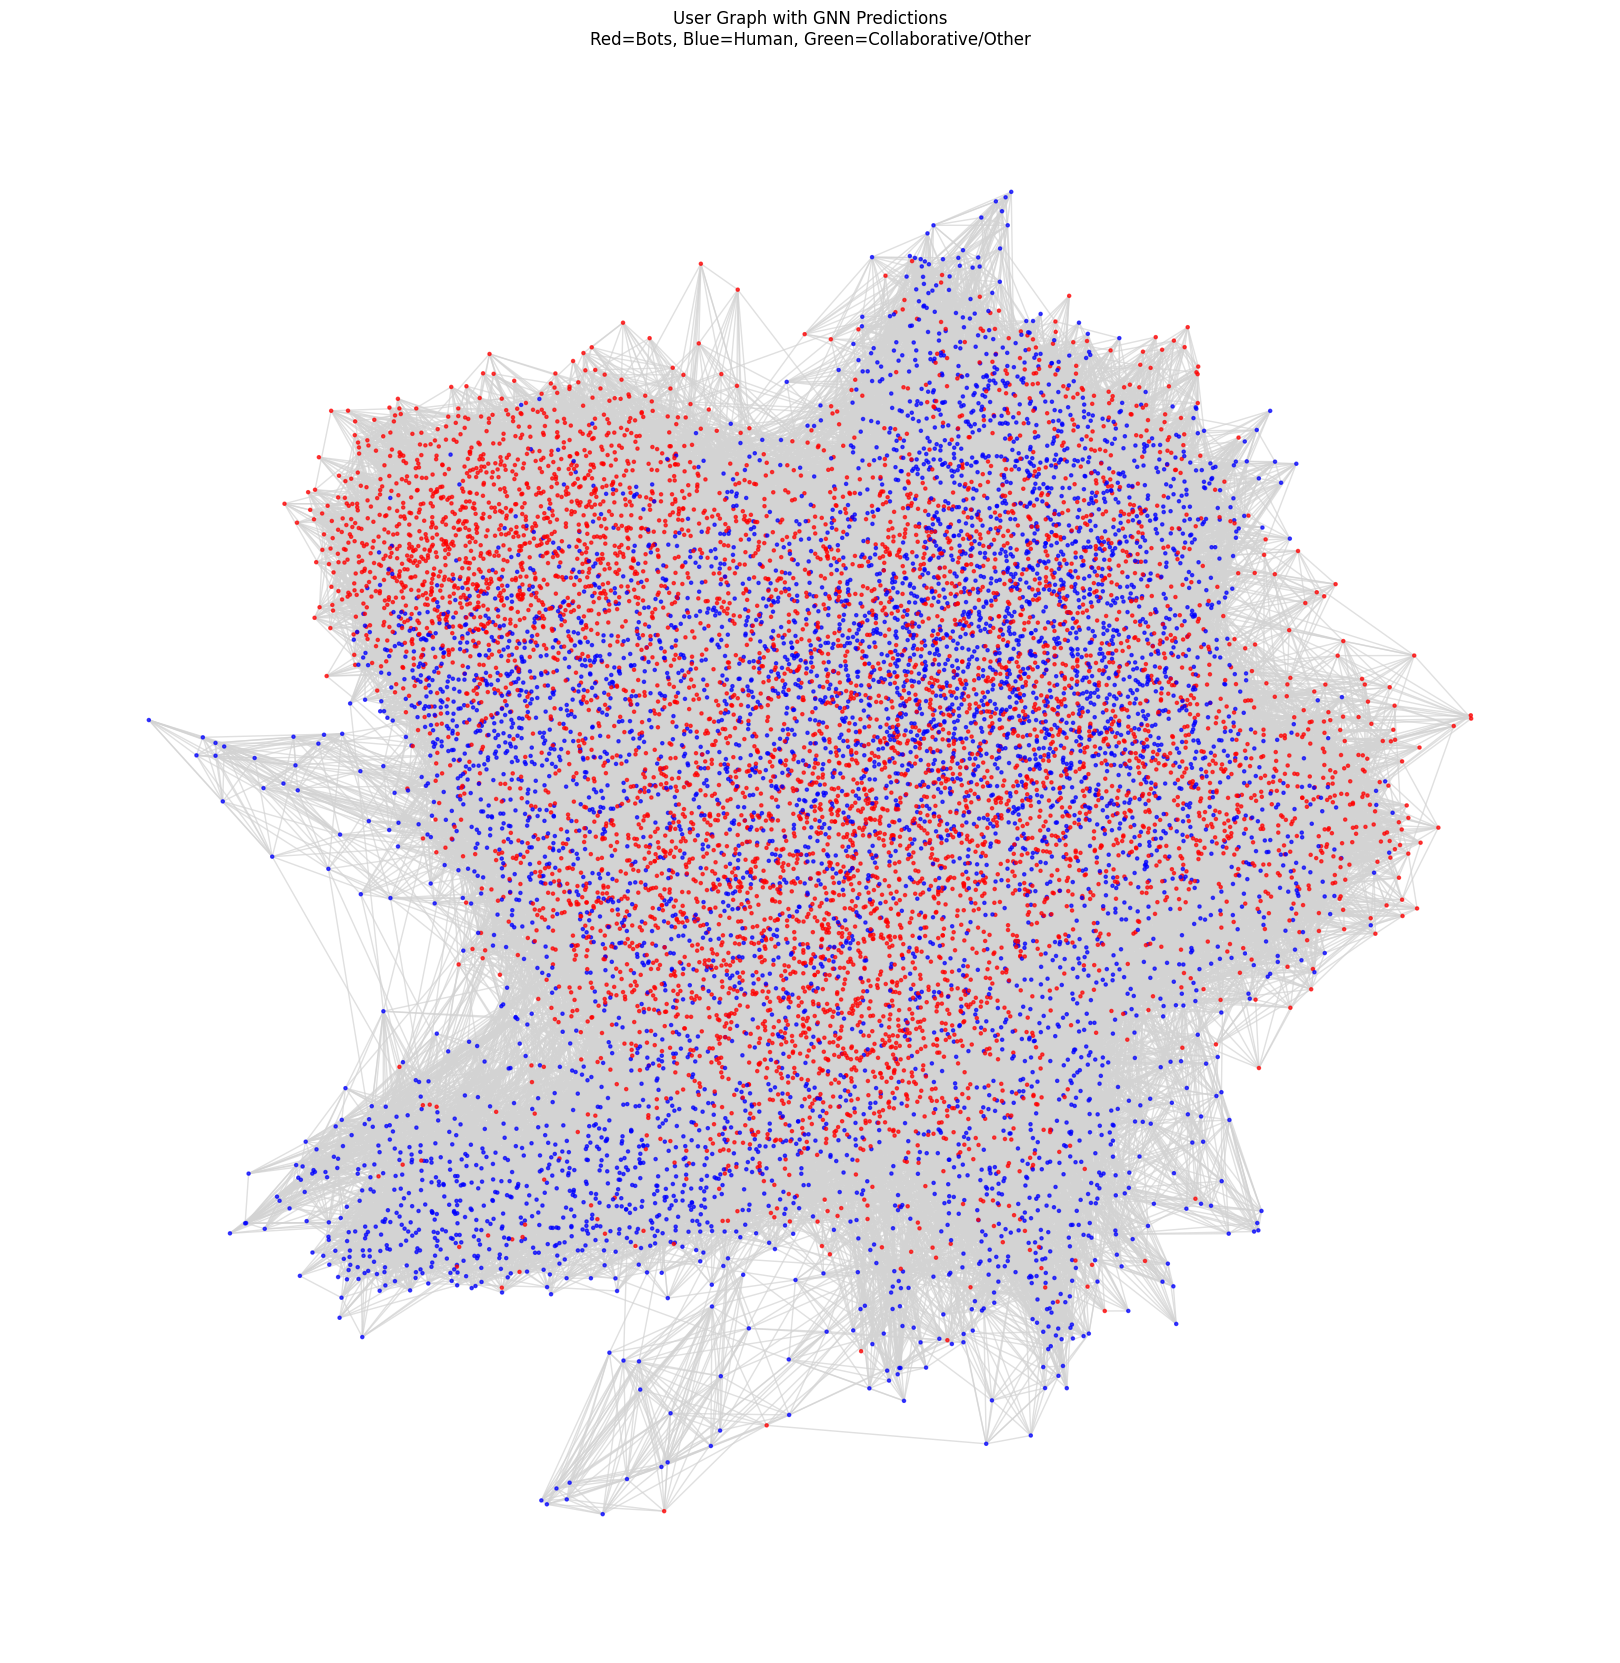

In [ ]:
pred_label_map = dict(zip(user_index['user_id'].astype(str), preds.cpu().numpy()))
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(zip(edges['src_user_id'].astype(str), edges['dst_user_id'].astype(str)))

color_map = []
for n in G.nodes():
    pred = pred_label_map.get(str(n), -1)
    if pred == 1:
        color_map.append('red')      # bot
    elif pred == 0:
        color_map.append('blue')     # human
    elif pred == 2:
        color_map.append('green')    # collaborative/other
    else:
        color_map.append('gray')     # unknown/not predicted

plt.figure(figsize=(16,16))
pos = nx.spring_layout(G, seed=42, k=0.13)
nx.draw(G, pos, node_color=color_map, with_labels=False, node_size=5, edge_color='lightgray', alpha=0.7)
plt.title('User Graph with GNN Predictions\nRed=Bots, Blue=Human, Green=Collaborative/Other')
plt.show()

In [ ]:
class BotGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)

        # Layer 1: Aggregates info from immediate friends (1-hop)
        self.conv1 = GCNConv(data.num_features, hidden_channels)

        # Layer 2: Aggregates info from friends of friends (2-hop)
        # Outputs 2 values: [Probability of Human, Probability of Bot]
        self.conv2 = GCNConv(hidden_channels, 2)

    def forward(self, x, edge_index):
        # Pass 1: Convolution -> ReLU Activation -> Dropout (to prevent overfitting)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Pass 2: Final Convolution
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BotGNN(hidden_channels=64).to(device)
data = data.to(device) # Move your graph data to the GPU/CPU
print("Model Architecture Created:")
print(model)

Model Architecture Created:
BotGNN(
  (conv1): GCNConv(384, 64)
  (conv2): GCNConv(64, 2)
)


In [ ]:
# Optimizer updates the weights; Criterion calculates the error
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index) # Forward pass

    # Calculate loss ONLY on training nodes (don't cheat with test data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    loss.backward() # Backward pass
    optimizer.step() # Update weights
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1) # Get the class with highest probability

    # Calculate accuracy on the Test set
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())
    return acc, pred

print("Starting Training...")
for epoch in range(201):
    loss = train()
    if epoch % 20 == 0:
        test_acc, _ = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

Starting Training...
Epoch: 000, Loss: 0.6921, Test Acc: 0.5772
Epoch: 020, Loss: 0.6083, Test Acc: 0.6445
Epoch: 040, Loss: 0.5632, Test Acc: 0.6726
Epoch: 060, Loss: 0.5484, Test Acc: 0.6658
Epoch: 080, Loss: 0.5400, Test Acc: 0.6871
Epoch: 100, Loss: 0.5391, Test Acc: 0.6829
Epoch: 120, Loss: 0.5342, Test Acc: 0.6905
Epoch: 140, Loss: 0.5195, Test Acc: 0.6863
Epoch: 160, Loss: 0.5261, Test Acc: 0.6743
Epoch: 180, Loss: 0.5138, Test Acc: 0.6914
Epoch: 200, Loss: 0.5113, Test Acc: 0.6863



Final GNN Test Accuracy: 0.5251

=== FINAL GNN CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       Human     0.3500    0.0390    0.0701       539
         Bot     0.5346    0.9385    0.6812       634

    accuracy                         0.5251      1173
   macro avg     0.4423    0.4887    0.3756      1173
weighted avg     0.4498    0.5251    0.4004      1173



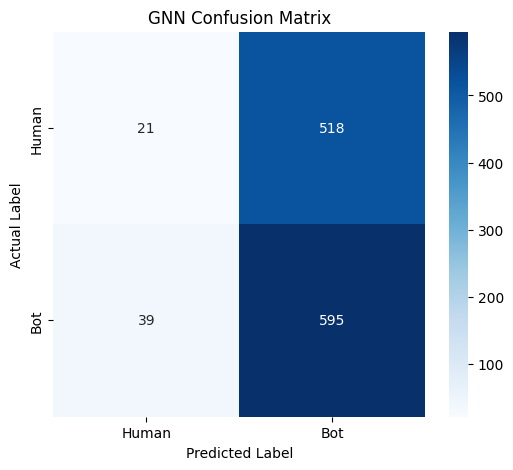

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions from the trained model
test_acc, preds = test()

# Move data to CPU so we can print it
y_true = data.y[data.test_mask].cpu().numpy()
y_pred = preds[data.test_mask].cpu().numpy()

print(f"\nFinal GNN Test Accuracy: {test_acc:.4f}")
print("\n=== FINAL GNN CLASSIFICATION REPORT ===")
# This is the table you need to show
print(classification_report(y_true, y_pred, target_names=['Human', 'Bot'], digits=4))

# Visualization: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Bot'], yticklabels=['Human', 'Bot'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('GNN Confusion Matrix')
plt.show()

In [ ]:
print("Baseline Logistic Regression Results:")
# (Paste or print your earlier text-only F1/precision/recall here)

print("\nGNN Node Classification Results:")
# (Print your latest GNN F1/precision/recall here)

Baseline Logistic Regression Results:

GNN Node Classification Results:


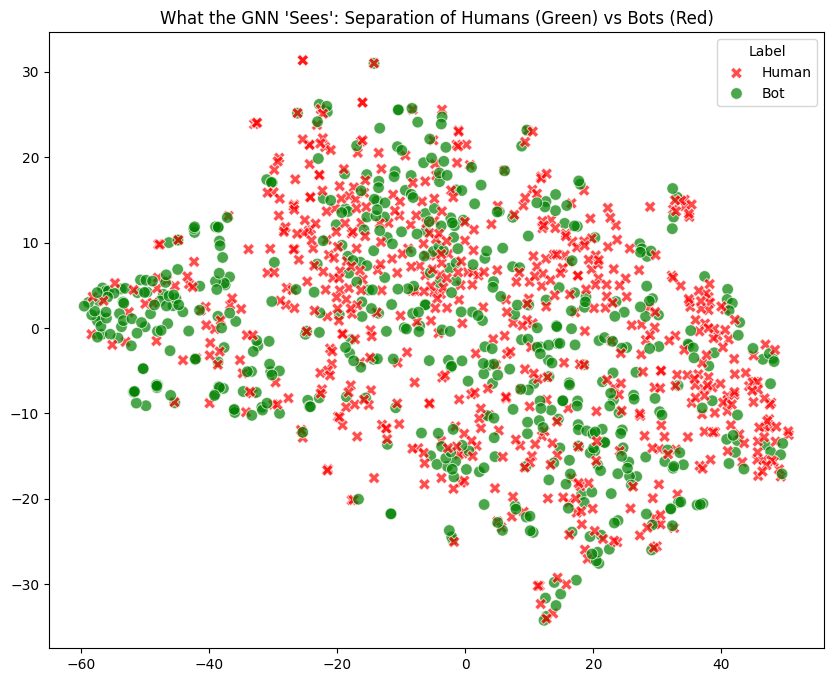

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the "hidden" representations (the learned features)
model.eval()
with torch.no_grad():
    # We use the output of the first layer to see what the GNN "learned"
    h = model.conv1(data.x, data.edge_index).relu()

# 2. Run TSNE to compress it to 2D for plotting
# Only plot a sample of 2000 nodes to keep it fast/readable
mask = data.test_mask
h_test = h[mask].cpu().numpy()
y_test = data.y[mask].cpu().numpy()

tsne = TSNE(n_components=2, random_state=42)
z = tsne.fit_transform(h_test)

# 3. Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=z[:,0], y=z[:,1], hue=y_test, palette={0:'green', 1:'red'}, style=y_test, s=70, alpha=0.7)
plt.title("What the GNN 'Sees': Separation of Humans (Green) vs Bots (Red)")
plt.legend(title='Label', labels=['Human', 'Bot'])
plt.show()

In [ ]:
# Get predictions
model.eval()
_, pred = model(data.x, data.edge_index).max(dim=1)

# Look at Test set only
test_indices = torch.where(data.test_mask)[0]

print("=== Success Stories: Users the GNN caught! ===")
for i in test_indices[:100]: # Check first 100 test users
    true_label = data.y[i].item()
    predicted_label = pred[i].item()

    # We want cases where the user IS A BOT (1) and we PREDICTED BOT (1)
    if true_label == 1 and predicted_label == 1:
        user_idx = i.item()
        # Get the original User ID (you need your 'user_index' dataframe loaded)
        # assuming 'user_index' is the dataframe mapping index -> user_id
        # original_id = user_index.iloc[user_idx]['user_id']

        print(f"Node Index: {user_idx} | True: Bot | Pred: Bot")
        print(f"   -> This user has {data.edge_index[0].eq(i).sum().item()} connections in the graph.")
        # If you have the dataframe loaded, you can print the tweet text here too!

=== Success Stories: Users the GNN caught! ===
Node Index: 5 | True: Bot | Pred: Bot
   -> This user has 10 connections in the graph.
Node Index: 44 | True: Bot | Pred: Bot
   -> This user has 10 connections in the graph.
Node Index: 45 | True: Bot | Pred: Bot
   -> This user has 13 connections in the graph.
Node Index: 48 | True: Bot | Pred: Bot
   -> This user has 12 connections in the graph.
Node Index: 56 | True: Bot | Pred: Bot
   -> This user has 10 connections in the graph.
Node Index: 66 | True: Bot | Pred: Bot
   -> This user has 14 connections in the graph.
Node Index: 68 | True: Bot | Pred: Bot
   -> This user has 12 connections in the graph.
Node Index: 95 | True: Bot | Pred: Bot
   -> This user has 12 connections in the graph.
Node Index: 96 | True: Bot | Pred: Bot
   -> This user has 11 connections in the graph.
Node Index: 122 | True: Bot | Pred: Bot
   -> This user has 11 connections in the graph.
Node Index: 172 | True: Bot | Pred: Bot
   -> This user has 10 connection

In [ ]:
# Check which classes exist in your data
print("Unique labels in dataset:", data.y.unique())

Unique labels in dataset: tensor([0, 1])
